## LTS Fortunoff Data Analysis

The goal of this notebook is to analyze the data provided by the Fortunoff Archive to the project *Let them Speak* and to offer quantitative insights into the data.

### Import the libraries needed

In [373]:
import sys; sys.path.insert(0, '..')
import pandas as pd
import os
from tqdm.notebook import tqdm
import constants
tqdm.pandas()
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))


/miniconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [374]:
from Utilities import mongo_helper
from Utilities import blacklab

### Load the necessary data into a panda dataframe

Get the testimonies metadata from the LTS database

In [375]:
collection = "Fortunoff"
db = "lts"
testimonies = mongo_helper.query(db,"testimonies",{'collection':collection},{'structured_transcript':0,'html_transcript':0,'_id':0})

In [376]:
df_testimonies = pd.DataFrame(testimonies)
df_testimonies =df_testimonies[df_testimonies['status']=="transcript_processed"]

In [377]:
if collection == "Fortunoff":
    additional_metadata=pd.read_csv(parent+'/Data/Output/'+'fortunoff_metadata.csv')
    df_testimonies = df_testimonies.merge(additional_metadata)

In [378]:
def normalize_interview_codes(int_code):
    import re
    int_code = int_code.split('-')[1]
    x = re.split("^0*",int_code)
    if len(x)>1:
        return 'HVT-'+x[1]
    else:
        'HVT-'+x[0]

Add additional metadata to various collections

In [379]:
import json
if collection == "Fortunoff":
    metadata=open(parent+'/Data/Input/Fortunoff_Metadata/index.8.min.json')
    text = metadata.read()
    additional_metadata = json.loads(text)
    df_metadata = pd.DataFrame(additional_metadata)
    df_metadata = df_metadata[['id','birth_place_countries',]]
    df_metadata = df_metadata.rename(columns={"id": "testimony_id"})
    df_metadata['testimony_id'] = df_metadata.testimony_id.apply(normalize_interview_codes)
    df_testimonies = df_testimonies.merge(df_metadata,on='testimony_id')

Load the word counts

In [380]:
word_counts =pd.read_csv(parent+'/Data/Output/'+'word_counts.csv')
df_testimonies = df_testimonies.merge(word_counts[['testimony_id','word_count']])

### Print the number of testimonies that are processed and in the dataset

In [381]:
print (len(df_testimonies[df_testimonies['status']=="transcript_processed"]))

176


### Make a historiogram about the distribution of interview years

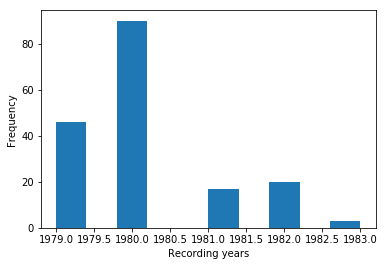

In [382]:
plot=df_testimonies.recording_year.plot.hist()
plot.set_xlabel("Recording years")
fig =plot.get_figure()
fig.savefig('distribution_interview_years_'+collection+'.png')

### Print the earliest and latest interviews

In [383]:
df_testimonies.recording_year.max()

1983

In [384]:
df_testimonies.recording_year.min()

1979

### Print the average token number

In [385]:
def get_token_counts(testimony_id):
    result = blacklab.iterable_results('[]',lemma=False,path_to_phrase_model=None,window=0,document_ids=[testimony_id])
    tokens = [element for element in result]
    return (len(tokens))

### Print the median token number

In [386]:
df_testimonies['word_count'].median()

12821.0

### Print the shortest interviews

In [387]:
df_testimonies.sort_values('word_count')[0:7][['testimony_title','word_count']]

,testimony_title,word_count
85,Varda H. Holocaust testimony (HVT-90),2475
15,Alexander L. Holocaust testimony (HVT-16),3476
109,Frania R. Holocaust testimony (HVT-115),3850
51,Mendel S. Holocaust testimony (HVT-56),3927
80,Kochevit P. Holocaust testimony (HVT-85),4547
112,Lee R. Holocaust testimony (HVT-118),5253
108,Joseph L. Holocaust testimony (HVT-114),5346


### Print the longest interviews

In [388]:
df_testimonies.sort_values('word_count',ascending=False)[0:5][['testimony_title','word_count']]

,testimony_title,word_count
150,Leo G. Holocaust testimony (HVT-158),38999
63,Hela S. Holocaust testimony (HVT-68),34924
46,Peter G. Holocaust testimony (HVT-51),32556
3,Sylvia B. and Frances G. Holocaust testimony (...,31237
47,Emma S. Holocaust testimony (HVT-52),30085


### Print a histogram

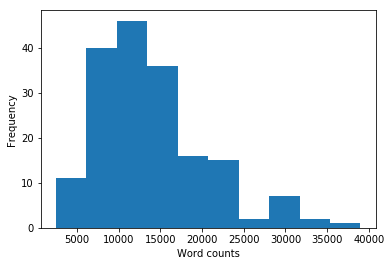

In [389]:
plot = df_testimonies.word_count.plot.hist()
plot.set_xlabel("Word counts")
fig =plot.get_figure()
fig.savefig('distribution_word_counts_'+collection+'.png')

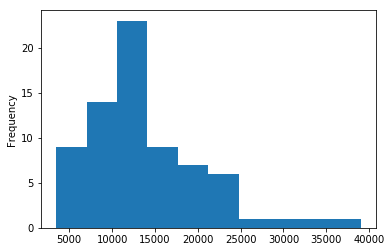

In [390]:
df_testimonies[df_testimonies.gender=="male"].word_count.plot.hist()

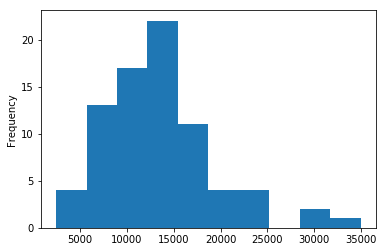

In [391]:
df_testimonies[df_testimonies.gender=="female"].word_count.plot.hist()

/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instea

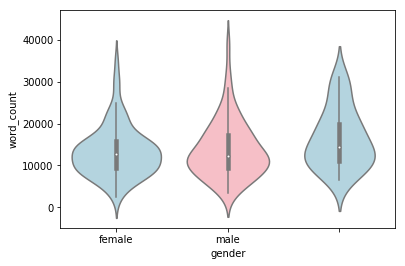

In [392]:
sns.violinplot("gender", "word_count", data=df_testimonies,
               palette=["lightblue", "lightpink"]);

### Print the number of men and women interviewees

First, women:

In [393]:
women = len(df_testimonies[(df_testimonies.gender=="female") & (df_testimonies.testimony_title.str.contains('and')==False)])

In [394]:
print (women)

78


In [395]:
print (women/len(df_testimonies))

0.4431818181818182


Second, men:

In [396]:
men = len(df_testimonies[(df_testimonies.gender=="male") & (df_testimonies.testimony_title.str.contains('and')==False)])

In [397]:
print (men)

71


In [398]:
print (men/len(df_testimonies))

0.4034090909090909


In [399]:
double = len(df_testimonies[df_testimonies.testimony_title.str.contains('and')==True])

In [400]:
df_testimonies[df_testimonies.testimony_title.str.contains('and')==True].testimony_title


3      Sylvia B. and Frances G. Holocaust testimony (...
11         Dora and Salo R. Holocaust testimony (HVT-12)
12     Shmuel S. and Dora R. Holocaust testimony (HVT...
13        Kurt and Trude S. Holocaust testimony (HVT-14)
15             Alexander L. Holocaust testimony (HVT-16)
19         Doni and Anna S. Holocaust testimony (HVT-21)
32     Rosalie W. and Jolly Z. Holocaust testimony (H...
35      Libby and Sidney G. Holocaust testimony (HVT-38)
52        Rose and Aaron M. Holocaust testimony (HVT-57)
59     Arnold and Lionel R. Holocaust testimony (HVT-64)
76       Henry and Chana F. Holocaust testimony (HVT-81)
84     Bronia and Nathan L. Holocaust testimony (HVT-89)
88        Jacob and Mira B. Holocaust testimony (HVT-93)
96         Eva and Carl S. Holocaust testimony (HVT-102)
110        Abe and Sari B. Holocaust testimony (HVT-116)
132       Abe and David F. Holocaust testimony (HVT-138)
134      David and Rosa G. Holocaust testimony (HVT-140)
135    Abraham P. and Morris P.

Print the number of double interviews

In [401]:
double

24

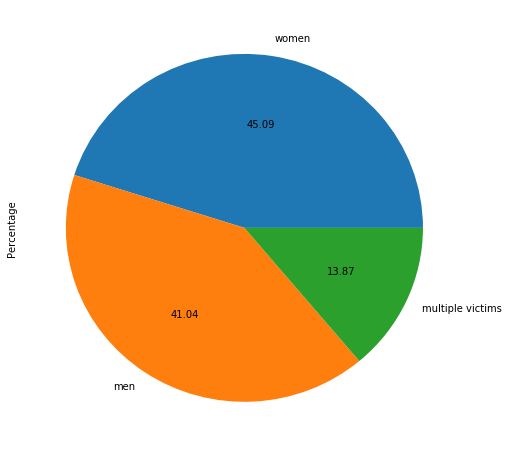

In [402]:
gender_plot = pd.DataFrame({'percentage':[women,men,double]},index=['women','men','multiple victims'])
plot = gender_plot.plot.pie(y='percentage',autopct='%.2f', figsize=(8, 8))
plot.set_ylabel("Percentage")
plot.get_legend().remove()
fig =plot.get_figure()
fig.savefig('percentage_women_men_'+collection+'.png')

In [403]:
df_testimonies.testimony_id[20]

'HVT-22'

In [404]:
def identify_country_of_birth(text):
    import spacy
    import pycountry
    hist_countries = ["Yugoslavia",'Czechoslovakia','Russia']
    countries = [element.name for element in list(pycountry.countries)]
    countries.extend(hist_countries)
    born_sentence=[]
    nlp = spacy.load('en_core_web_sm') # Load the English Model
    doc = nlp(text)
    result = []
    for i,sent in enumerate(doc.sents):
        sentence_tokens = [token.text for token in sent]
        if "born" in sentence_tokens:
            labels = [token.text for token in sent]
            doc = nlp(' '.join(labels))
            if doc.ents:
                for element in doc.ents:
                    if (element.text in countries):
                        result.append(element.text)
            break
        if i==3:
            break
    if len(result)==1:
        return result[0]
    elif len(result)>1:
        return "fuzzy"
    else:
        return None

In [405]:
#df_testimonies['country_of_birth'] = df_testimonies.interview_summary.progress_apply(identify_country_of_birth)

### Visualize the distribution of year of births

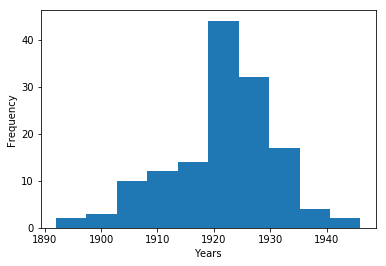

In [406]:
plot = df_testimonies.interviewee_year_of_birth.plot.hist()
plot.set_xlabel("Years")
fig =plot.get_figure()
fig.savefig('year_of_birth_all_frequency_'+collection+'.png')

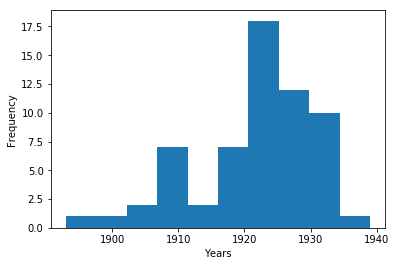

In [407]:
plot = df_testimonies[df_testimonies.gender=="female"].interviewee_year_of_birth.plot.hist()
plot.set_xlabel("Years")
fig =plot.get_figure()
fig.savefig('year_of_birth_women_frequency_'+collection+'.png')

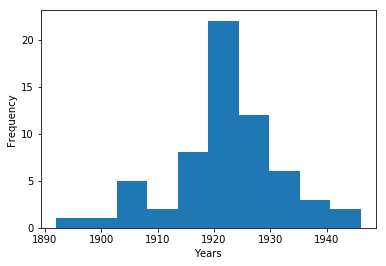

In [408]:
plot = df_testimonies[df_testimonies.gender=="male"].interviewee_year_of_birth.plot.hist()
plot.set_xlabel("Years")
fig =plot.get_figure()
fig.savefig('year_of_birth_men_frequency_'+collection+'.png')

In [409]:
women = df_testimonies[df_testimonies.gender=="female"][['interviewee_year_of_birth']]
men = df_testimonies[df_testimonies.gender=="male"][['interviewee_year_of_birth']]
#df = pd.DataFrame([women,men],index=['women','men'])

/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


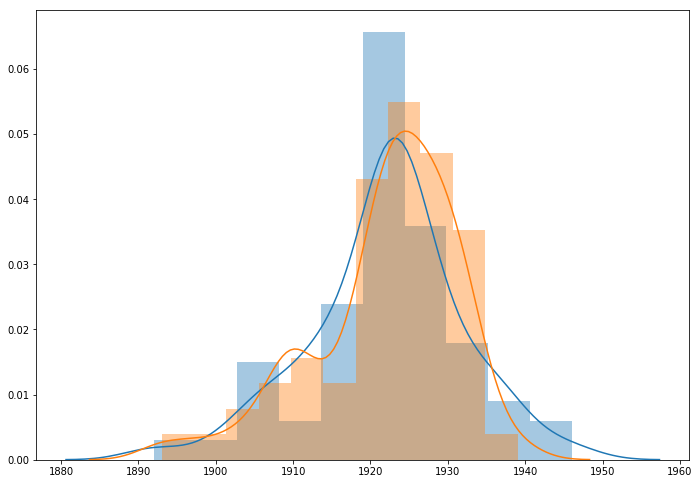

In [410]:
import seaborn as sns
import matplotlib.pyplot as plt
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(men[['interviewee_year_of_birth']].dropna(), hist=True, rug=False,label="Men")
sns.distplot(women[['interviewee_year_of_birth']].dropna(), hist=True, rug=False,label = 'Female')

In [411]:
df_testimonies.interviewee_year_of_birth.min()

1892.0

In [412]:
df_testimonies.interviewee_year_of_birth.mean()

1921.35

### Study the age of interviewee when interview given

In [413]:
df_testimonies['age_interview_year']=df_testimonies['recording_year']-df_testimonies['interviewee_year_of_birth']

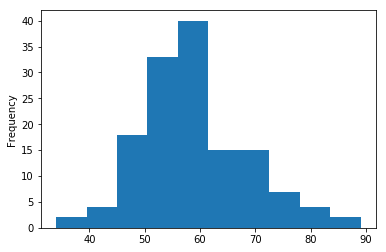

In [414]:
df_testimonies['age_interview_year'].plot.hist()

In [415]:
df_testimonies['age_interview_year'].mean()

58.82857142857143

Look at women

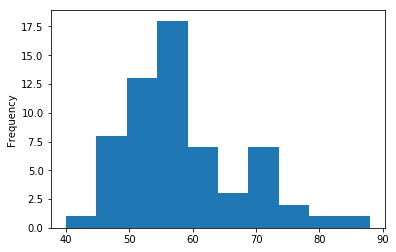

In [417]:
df_testimonies[df_testimonies.gender=="female"]['age_interview_year'].plot.hist()

In [418]:
df_testimonies[df_testimonies.gender=="female"]['age_interview_year'].describe()

count    61.000000
mean     58.327869
std       9.570304
min      40.000000
25%      52.000000
50%      56.000000
75%      62.000000
max      88.000000
Name: age_interview_year, dtype: float64

Look at men

In [419]:
df_testimonies[df_testimonies.gender=="male"]['age_interview_year'].describe()

count    62.000000
mean     58.145161
std      10.097633
min      34.000000
25%      53.250000
50%      57.000000
75%      63.500000
max      89.000000
Name: age_interview_year, dtype: float64

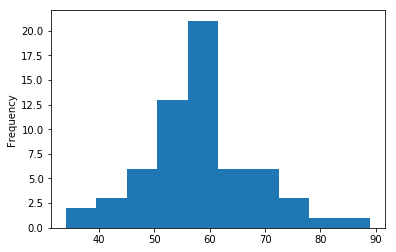

In [420]:
df_testimonies[df_testimonies.gender=="male"]['age_interview_year'].plot.hist()

## Look at the distribution of countries of birth of interviewees

In [421]:
countries_not_separated = df_testimonies.birth_place_countries.to_list()
countries = []
for country in countries_not_separated:
    countries.extend(country)
from collections import Counter
df_countries = pd.DataFrame.from_dict(Counter(countries), orient='index').reset_index()
df_countries = df_countries.sort_values(0,ascending=False)
df_countries = df_countries.dropna()

In [422]:
df_countries

,index,0
1,Poland,91
0,Germany,24
10,Hungary,10
3,Austria,9
8,Slovakia,9
2,Ukraine,9
4,Bukovina,6
12,Czech Republic,5
15,Romania,5
7,Czechoslovakia,4


Look at women

In [423]:
countries_not_separated = df_testimonies[df_testimonies.gender=="female"].birth_place_countries.to_list()
countries = []
for country in countries_not_separated:
    countries.extend(country)
from collections import Counter
df_countries = pd.DataFrame.from_dict(Counter(countries), orient='index').reset_index()
df_countries = df_countries.sort_values(0,ascending=False)
df_countries = df_countries.dropna()
df_countries_w = df_countries


In [424]:
df_countries

,index,0
1,Poland,36
0,Germany,9
6,Hungary,5
7,Slovakia,5
3,Ukraine,4
12,Czech Republic,3
14,Serbia,2
9,Belgium,2
8,Russia,2
5,Netherlands,2


Look at men

In [425]:
countries_not_separated = df_testimonies[df_testimonies.gender=="male"].birth_place_countries.to_list()
countries = []
for country in countries_not_separated:
    countries.extend(country)
from collections import Counter
df_countries = pd.DataFrame.from_dict(Counter(countries), orient='index').reset_index()
df_countries = df_countries.sort_values(0,ascending=False)
df_countries = df_countries.dropna()
df_countries_m = df_countries
display(df_countries)

,index,0
0,Poland,30
5,Germany,12
3,Austria,5
2,Czechoslovakia,3
13,Romania,3
4,Slovakia,2
8,Czech Republic,2
11,Hungary,2
1,Ukraine,1
7,Bukovina,1


Only men countries

In [426]:
df_countries_w = df_countries_w.reset_index()['index'].to_list()
df_countries_m = df_countries_m.reset_index()['index'].to_list()

In [427]:
for element in df_countries_m:
        if element not in df_countries_w:
            print (element)

France
Kenya


Visualize it

In [428]:
countries_not_separated = df_testimonies.birth_place_countries.to_list()
countries = []
for country in countries_not_separated:
    countries.extend(country)
from collections import Counter
df_countries = pd.DataFrame.from_dict(Counter(countries), orient='index').reset_index()
df_countries = df_countries.sort_values(0,ascending=False)
df_countries = df_countries.dropna()
df_countries.reset_index()

,level_0,index,0
0,1,Poland,91
1,0,Germany,24
2,10,Hungary,10
3,3,Austria,9
4,8,Slovakia,9
5,2,Ukraine,9
6,4,Bukovina,6
7,12,Czech Republic,5
8,15,Romania,5
9,7,Czechoslovakia,4


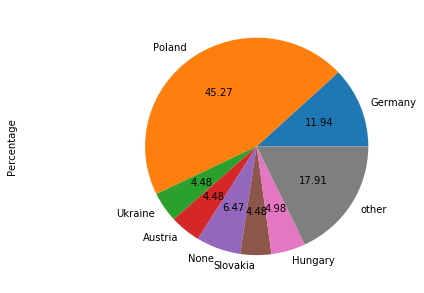

In [432]:
locations = pd.DataFrame.from_dict(Counter(countries), orient='index')[0]
locations = pd.DataFrame(locations)
sum_other = locations[locations<7].sum()
locations= locations[locations>7]
locations.loc['other'] = sum_other
locations = locations.dropna()
plot = locations[0].plot.pie(autopct='%.2f', figsize=(5, 5))
plot.set_ylabel("Percentage",labelpad=100)
fig =plot.get_figure()
fig.savefig('percentage_coutry_of_birth_locations_'+collection+'.png')




## Render the Interview Locations

In [430]:
df_testimonies.interview_location.value_counts()

New Haven, Conn. :                        79
New York, N.Y. :                          31
Boston, Mass. :                           16
Hartford, Conn. :                         12
Bridgeport, Conn. :                       10
Tel Aviv, Israel :                         7
Palm Beach, Fla. :                         6
Kansas City, Mo. :                         6
Jerusalem, Israel :                        5
Norfolk, Va. :                             1
New York, N.Y. and Jerusalem, Israel :     1
Bridgeport and New Haven, Conn. :          1
Lawrence, N.Y. :                           1
Name: interview_location, dtype: int64